The equations used in [paper](https://arxiv.org/abs/physics/0701150) are : 

$$ H \varphi (x,t)= i \hbar \frac {\partial}{\partial t} \varphi (x,t) \newline
\text{where}~ ~ H = -\frac{\hbar^2 }{2m} \frac {\partial^2}{\partial x^2} + V(x) 
\newline 
\varphi (x,t+\Delta t) = \varphi(x,t) e^{-iH\Delta t/\hbar}
$$

Where the time-evolution operator $e^{-iH\Delta t/\hbar}$ can be expanded to give a unitary approximation of the operator by setting

$$
e^{-iH\Delta t/\hbar} = \frac {1 - \frac 1 2 iH\Delta t/\hbar}{1 + \frac 1 2 iH\Delta t/\hbar} + O((\Delta t)^3)
$$
with error of order $(\Delta t)^3$ 

Further gernalizing the 5 point and 7 point formula to a 2r+1 point formula to get double differentiation as per required to calculate operator H we have ,
$$
y^{''}(x) = \frac 1 {h^2} \Sigma _{k = -r} ^ {k = r} c_k ^{(r)} y(x+kh) + O(h^{2r})
$$

To obtain these constants we make expansions as : 
$$
y(x+kh) = y(x) + (kh)y'(x) + \frac 1 {2!} (kh)^2 y''(x) + ... + \frac 1 {(2r+1)!} y^{2r+1} (x) + O(h^{2r+2})
\newline
y(x-kh) = y(x) - (kh)y'(x) + \frac 1 {2!} (kh)^2 y''(x) + ... + \frac {(-1)^{2r+1}} {(2r+1)!} y^{2r+1} (x) + O(h^{2r+2})
 $$

Adding both the above equations and making the system as matrix for unknown variable we get as 
$$
AY = Y_r
$$

$$ 
\begin{pmatrix}
\frac {2(h^2)}{2!} & \frac {2(h^4)}{4!} & \cdots & \frac {2(h^{2r})}{2r!} \\
\frac {2(2h)^2}{2!} & \frac {2(2h)^4}{4!} & \cdots & \frac {2(2h)^{2r}}{2r!} \\
\vdots & \vdots & \ddots & \vdots \\
\frac {2(rh)^2}{2!} & \frac {2(rh)^4}{4!} & \cdots & \frac {2(rh)^{2r}}{2r!} 
\end{pmatrix} 
\cdot
\begin{pmatrix}
y^2 (x) & \\
y^4 (x)                     \\
\vdots               \\
y^{2r} (x)
\end{pmatrix}
= 
\begin{pmatrix}
y(x+h) + y(x-h) -2y(x) \\
y(x+2h) + y(x-2h) -2y(x) \\
\vdots\\
y(x+rh) + y(x-rh) -2y(x)
\end{pmatrix}
$$

In [3]:
# Code to get coffecients as per part II of paper to get differentials 
function getDerivativeCoeff(r)
    h = 1         #This does not affect the final values
    coeffMatrix = zeros(Float64, r, r)
    for row in 1:r
        for col in 1:r
            coeffMatrix[row, col] = 2*((row*h)^(col*2))/factorial(2*col)  #Updating the coefficient matrix for linear system
        end
    end
    inverse = inv(coeffMatrix)                                      #Inverting the matrix
    ret = Vector{Float64}()
    push!(ret,(h^2)*(-2*sum(inverse[1, :])))
    for i in 1:r
        push!(ret,inverse[1, i])
    end 
    return ret
end
for r in 1:5
    coeff = getDerivativeCoeff(r)
    println(coeff)
end

[-2.0, 1.0]
[-2.5, 1.3333333333333333, -0.08333333333333331]
[-2.7222222222222223, 1.5, -0.15000000000000002, 0.011111111111111127]
[-2.8472222222222374, 1.6000000000000119, -0.2000000000000055, 0.02539682539682675, -0.0017857142857144043]
[-2.9272222222222464, 1.666666666666686, -0.2380952380952478, 0.039682539682542595, -0.004960317460317942, 0.0003174603174603552]


In [4]:
using SparseArrays, Plots, LinearAlgebra
function timeEvolutionMatrix(; spatialPotential, r, Δt, Δx, ħ, m, z_s)
    ret = 1I
    for z in z_s
        b = im*ħ*Δt/(2*m*(Δx)^2)
        c = getDerivativeCoeff(r)
        a = c*b/z
        d = [1+a[1]-spatialPotential[i]*(im*Δt/ħ)/z for i in 1:length(spatialPotential)]
        I = [i for i in 1:length(spatialPotential)]
        J = [i for i in 1:length(spatialPotential)]
        V = copy(d)
        for i in 1:r
            hor = [j for j in 1:(length(spatialPotential)-i)]
            ver = [j+i for j in 1:(length(spatialPotential)-i)]
            I = [I;hor;ver]
            J = [J;ver;hor]
            V = [V; [a[i+1] for j in 1:2*(length(spatialPotential)-i)]]
        end
        A = Matrix(sparse(I, J, V))
        ret = ret*inv(A)*conj.(A)
    end
    return ret
end

timeEvolutionMatrix (generic function with 1 method)

In [5]:
# Having a potential function to test
function V(x)
    k = pi / 10
    return [1 + cos(k*x)]
end

V (generic function with 1 method)

In [6]:
using Polynomials
using Printf

function getPadeRoots(m)
    c_i =[]
    a_i = Vector{Float64}()
    b_i = Vector{Float64}()
    for i in 0:2*m
        push!(c_i, 1/factorial(i))
    end

    lhMatrix = zeros(Float64, m, m)
    for i in 1:m
        for j in 1:m
            lhMatrix[i, j] = c_i[m+i-j+1]
        end
    end

    rhMatrix = zeros(Float64, m, 1)
    for i in 1:m
        rhMatrix[i, 1] = -1*c_i[m+i+1]
    end

    inverse = inv(lhMatrix)
    res = inverse*rhMatrix
    push!(b_i, 1)
    for i in 1:m
        push!(b_i, res[i,1])
    end 

    for i in 0:m
        sum = 0
        for j in 0:i
            sum = sum+c_i[j+1]*b_i[i-j+1]
        end
        push!(a_i, sum)
    end
    root = roots(Polynomial(a_i))
    return root
end

for m in 1:5
    root = getPadeRoots(m)
    for i in 1:m
            @printf "%.5f" real(root[i])
            # print(" ")
            if imag(root[i])>=0
                print("+")
            end
            @printf "%.5f" imag(root[i])
            print("i ")
    end
    print("\n")
end

-2.00000+0.00000i 
-3.00000-1.73205i -3.00000+1.73205i 
-4.64437+0.00000i -3.67781-3.50876i -3.67781+3.50876i 
-5.79242-1.73447i -5.79242+1.73447i -4.20758-5.31484i -4.20758+5.31484i 
-7.29348+0.00000i -6.70391-3.48532i -6.70391+3.48532i -4.64935-7.14205i -4.64935+7.14205i 


┌ Info: Saved animation to C:\Users\alpha\AppData\Local\Temp\jl_yFeF2Tupod.gif
└ @ Plots C:\Users\alpha\.julia\packages\Plots\nuwp4\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\alpha\\AppData\\Local\\Temp\\jl_yFeF2Tupod.gif")
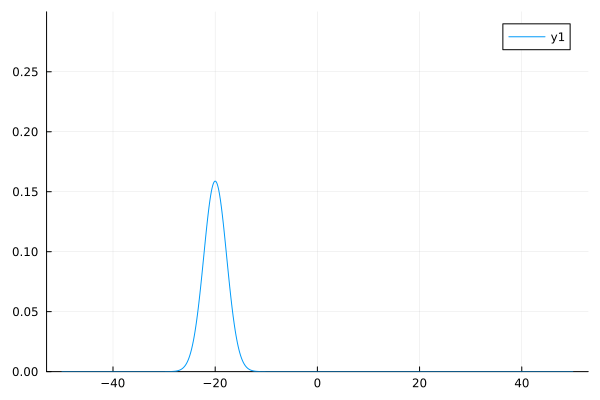

In [11]:
ħ = 1
mass = 1
padeM=5

Δt = 0.1
Δx = 0.1

x_vals = -50:Δx:50
t_vals = 0:Δt:50

# Initialize and evolve the wavefunction
Ψ_vals = (x -> exp(-(x+20)^2/10 - im*5/ħ*x)).(x_vals)
Ψ_vals = Ψ_vals / sqrt(sum(Ψ_vals .* conj.(Ψ_vals)))

# infinite potential well
function potential_well(x)
    if abs(x) < 40
        return 0
    else
        return 1E3
    end
end

# potential_vals = (x -> x).(x_vals)
potential_vals = (x -> potential_well(x)).(x_vals)
Ψ_grid = copy(Ψ_vals)

K=I
padeRoots = getPadeRoots(padeM)
for i in 1:padeM
    K = K*timeEvolutionMatrix(spatialPotential=potential_vals,r=3, Δt=Δt, Δx=Δx, m=mass, ħ=ħ,z_s=padeRoots[i])
end
for t_i in 2:length(t_vals)
    Ψ_grid = hcat(Ψ_grid, K * Ψ_grid[:,t_i-1])
end

@gif for t_i in 1:length(t_vals)
    plot(x_vals,abs.(Ψ_grid[:,t_i]))
    ylims!(0,0.3)
end